In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import copy

import torchmetrics
from utils.model import FLNet
from utils.local_train import LocalTraining
from utils.utils import Utils
from utils.fusion import Fusion, FusionAvg, FusionRetrain

from tqdm import tqdm

#### FL Fusion Class Selection

In [2]:
def FL_round_fusion_selection(num_parties, fusion_key='FedAvg'):

    fusion_class_dict = {
        'FedAvg': FusionAvg(num_parties),
        'Retrain': FusionRetrain(num_parties),
        'Unlearn': FusionAvg(num_parties)
        }

    return fusion_class_dict[fusion_key]

#### Set up No. of Parties, Party to be Erased, and Attack Parameters

In [3]:
class T_Dataset(torch.utils.data.Dataset):

    def __init__(self, csv, client):
        # read the csv file
        self.df = pd.read_csv(csv, sep=',')
        # self.df = self.df.dropna(axis=0)
        # save cols
        self.output_cols = ['Cover_Type']
        self.input_cols = list(set(self.df.columns)-set(self.output_cols))
        self.client = client
        self.df = self.df.loc[self.df["Cover_Type"]==client]


    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.df)


    def __getitem__(self, idx):
        # here i will load the file in position idx
        cur_sample = self.df.iloc[idx]
        # split in input / ground-truth
        cur_sample_x = cur_sample[self.input_cols]
        cur_sample_y = cur_sample[self.output_cols]
        # convert to torch format
        cur_sample_x = torch.tensor(cur_sample_x.tolist())
        cur_sample_y = torch.tensor(cur_sample_y.tolist())
        # remove dimension on gt
        cur_sample_y = cur_sample_y.squeeze()
        # convert to int
        cur_sample_y = cur_sample_y.long() - 1
        # return values
        return cur_sample_x, cur_sample_y

class Dataset(torch.utils.data.Dataset):

    def __init__(self, csv):
        # read the csv file
        self.df = pd.read_csv(csv, sep=',')
        # self.df = self.df.dropna(axis=0)
        # save cols
        self.output_cols = ['Cover_Type']
        self.input_cols = list(set(self.df.columns)-set(self.output_cols))


    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.df)


    def __getitem__(self, idx):
        # here i will load the file in position idx
        cur_sample = self.df.iloc[idx]
        # split in input / ground-truth
        cur_sample_x = cur_sample[self.input_cols]
        cur_sample_y = cur_sample[self.output_cols]
        # convert to torch format
        cur_sample_x = torch.tensor(cur_sample_x.tolist())
        cur_sample_y = torch.tensor(cur_sample_y.tolist())
        # remove dimension on gt
        cur_sample_y = cur_sample_y.squeeze()
        # convert to int
        cur_sample_y = cur_sample_y.long() - 1
        # return values
        return cur_sample_x, cur_sample_y



In [ ]:
# create train and validation datasets
trainloader_lst = []
for i in range(1,8):
    ds = T_Dataset('ForestDataset/train.csv', i)
    trainloader_lst.append(torch.utils.data.DataLoader(ds,
    batch_size = 20,
    drop_last = True,
    shuffle = True)
)

### Train

In [5]:
device = 'cuda'
learning_rate = 1e-5
batch_size = 20
experiment_name = 'prova1'
n_inputs = 54
n_classes = 7

class Dataset(torch.utils.data.Dataset):

    def __init__(self, csv):
        # read the csv file
        self.df = pd.read_csv(csv, sep=',')
        # self.df = self.df.dropna(axis=0)
        # save cols
        self.output_cols = ['Cover_Type']
        self.input_cols = list(set(self.df.columns)-set(self.output_cols))


    def __len__(self):
        # here i will return the number of samples in the dataset
        return len(self.df)


    def __getitem__(self, idx):
        # here i will load the file in position idx
        cur_sample = self.df.iloc[idx]
        # split in input / ground-truth
        cur_sample_x = cur_sample[self.input_cols]
        cur_sample_y = cur_sample[self.output_cols]
        # convert to torch format
        cur_sample_x = torch.tensor(cur_sample_x.tolist())
        cur_sample_y = torch.tensor(cur_sample_y.tolist())
        # remove dimension on gt
        cur_sample_y = cur_sample_y.squeeze()
        # convert to int
        cur_sample_y = cur_sample_y.long() - 1
        # return values
        return cur_sample_x, cur_sample_y


In [ ]:
# create train and validation datasets
train_ds = Dataset('ForestDataset/train.csv')
val_ds =  Dataset('ForestDataset/val.csv')

In [7]:
# create train dataloader
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size = batch_size,
    drop_last = True,
    shuffle = True
)
# create validation dataloader
val_dl = torch.utils.data.DataLoader(
    val_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False
)

In [8]:
class Net(nn.Sequential):
    def __init__(self, n_inputs, n_classes):
        super(Net, self).__init__(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, n_classes)
        )


In [9]:
# create validation routine
def validate(net, dl, n_classes, device):
    # create metric objects
    tm_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average= 'macro', top_k=1)
    tm_con = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=n_classes)
    # move metric to device
    net.to(device)
    tm_acc.to(device)
    tm_con.to(device)
    # set network in eval mode
    net.eval()
    # at the end of epoch, validate model
    for inp, gt in dl:
        # move batch to gpu
        inp = inp.to(device)
        gt = gt.to(device)
        # remove singleton dimension
        gt = gt.squeeze()
        # get output
        with torch.no_grad():
            # perform prediction
            logits = net(inp)
        # update metrics
        tm_acc.update(logits, gt)
        tm_con.update(logits, gt)

    # at the end, compute metric
    acc = tm_acc.compute()
    con = tm_con.compute()
    # set network in training mode
    net.train()
    # return score
    return acc, con

In [10]:
import seaborn as sns

def plot_confusion_matrix(conf_mat):
    cm = sns.light_palette("blue", as_cmap=True)
    x=pd.DataFrame(conf_mat.cpu())
    x=x.style.background_gradient(cmap=cm)
    display(x)

In [11]:
from torch.utils.tensorboard import SummaryWriter
# initialize the network
net = Net(n_inputs, n_classes)

# move to device
net.to(device)

# define optimizer
optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)

# define summary writer
writer = SummaryWriter(experiment_name)

# initialize iteration number
n_iter = 0

# define best validation value
best_acc = None

# define loss function
loss_fun = nn.CrossEntropyLoss()

# for each epoch
for cur_epoch in range(100):

    # plot current epoch
    writer.add_scalar("epoch", cur_epoch, n_iter)
    # for each batch
    for inp, gt in train_dl:
        # move batch to gpu
        inp = inp.to(device)
        gt = gt.to(device)
        # reset gradients
        optimizer.zero_grad()
        # get output
        logits = net(inp)
        # compute loss
        loss = loss_fun(logits, gt.squeeze())
        # compute backward
        loss.backward()
        # update weights
        optimizer.step()
        # plot
        writer.add_scalar("loss", loss.item(), n_iter)
        n_iter += 1

    # at the end, validate model
    cur_acc, cur_conf_mat = validate(net, val_dl, n_classes, device)
    # plot validation
    writer.add_scalar("accuracy", cur_acc.item(), n_iter)
    # check if it is the best model so far
    if best_acc is None or cur_acc > best_acc:
        # define new best val
        best_acc = cur_acc
        # save current model as best
        torch.save({
            'net': net.state_dict(),
            'opt': optimizer.state_dict(),
            'epoch': cur_epoch
        }, experiment_name + '_best.pth')
    # save last model
    torch.save({
        'net': net.state_dict(),
        'opt': optimizer.state_dict(),
        'epoch': cur_epoch
    }, experiment_name + '_last.pth')


In [ ]:
# create test dataset
test_ds =  Dataset('ForestDataset/test.csv')

# create dataloader
test_dl = torch.utils.data.DataLoader(
    test_ds,
    batch_size = batch_size,
    drop_last = False,
    shuffle = False
)

In [13]:
test_accuracy, test_conf_mat = validate(net, test_dl, n_classes, "cuda")
print(f'The model scored an accuracy of {test_accuracy:0.04f} over the testset.')
plot_confusion_matrix(test_conf_mat)

The model scored an accuracy of 0.6794 over the testset.


,0,1,2,3,4,5,6
0,127,49,1,0,6,1,17
1,45,127,2,0,31,4,4
2,0,4,114,38,15,76,0
3,0,0,6,165,0,9,0
4,12,29,12,0,181,10,0
5,0,5,53,16,18,128,0
6,35,1,0,0,0,0,171


In [14]:
# Make sure you have the proper imports
from backpack import backpack, extend
from backpack.extensions import DiagHessian

def compute_diag_hessian(model, criterion, inputs, targets, device='cpu'):
    inputs = inputs.to(device)
    targets = targets.to(device)

    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    with backpack(DiagHessian()):
        loss.backward()

    diag_hessian_params = {}
    for name, param in model.named_parameters():
        if hasattr(param, 'diag_h'):
            if param.requires_grad:
                diag_hessian_params[name] = param.diag_h.clone().detach()
                del param.diag_h

    return diag_hessian_params

def calculate_accumulated_diag_hessian(dataloader_list, model, criterion, weights=None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Store Hessians and batch counts per client
    client_hessians = []
    total_batches = 0
    
    # Calculate diagonal Hessian for each client
    for loader_idx, loader in enumerate(dataloader_list):
        accumulated_diag_h = {}
        print(f"Calculating diagonal Hessian for client {loader_idx}")
        
        for batch_idx, (inputs, targets) in enumerate(loader):
            # Compute diagonal Hessian for this batch
            diag_h = compute_diag_hessian(model, criterion, inputs, targets, device=device)
            
            # Accumulate values
            for name, value in diag_h.items():
                if name not in accumulated_diag_h:
                    accumulated_diag_h[name] = value
                else:
                    accumulated_diag_h[name] += value
            
            total_batches += 1
        
        # Store results for this client
        client_hessians.append(accumulated_diag_h)


    # Normalize client importance weights
    if weights is None:
        weights = [1.0] * len(dataloader_list)

    # Weighted average of client Hessians
    weighted_avg_hessian = {}
    for name in client_hessians[0].keys():
        weighted_avg_hessian[name] = sum(
            client_hessians[i][name] * weights[i] for i in range(len(client_hessians))
        ) / total_batches
    
    return weighted_avg_hessian


In [15]:
party_to_be_erased = 1

trainloader_list = [DataLoader(dloader.dataset, batch_size=20) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 

#Use the model if coming from the training or load if you have it downloaded
final_model = copy.deepcopy(net)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.0001

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 1 - delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)

weights_half = weights_unlearned
weights_half[party_to_be_erased] = 1 - delta / 2


Compute Hessians

In [16]:
accumulated_diag_h = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion)
accumulated_diag_h_removed = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_unlearned)

Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4
Calculating diagonal Hessian for client 5
Calculating diagonal Hessian for client 6
Calculating diagonal Hessian for client 0
Calculating diagonal Hessian for client 1
Calculating diagonal Hessian for client 2
Calculating diagonal Hessian for client 3
Calculating diagonal Hessian for client 4
Calculating diagonal Hessian for client 5
Calculating diagonal Hessian for client 6


OUR METHOD

In [17]:
def compute_true_info(hessian, hessian_delta, delta):
    A_list = [torch.empty_like(p) for p in hessian.values()]
    B_list = [torch.empty_like(p) for p in hessian.values()]
    for i,k in enumerate(hessian.keys()): 
        print(k)

        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        ratio = hessian_delta[k]/hessian[k]
        A=1/2 * torch.log(ratio)/delta
        B=1/2 * (1-ratio)/delta

        A[degeneracies_indices]=0
        B[degeneracies_indices]=0

        assert torch.sum(torch.isnan(A))==0, f"NaN values in A: {torch.sum(torch.isnan(A))}"
        assert torch.sum(torch.isnan(B))==0, f"NaN values in B: {torch.sum(torch.isnan(B))}"
        assert torch.sum(torch.isinf(A))==0, f"Inf values in A: {torch.sum(torch.isinf(A))}"
        assert torch.sum(torch.isinf(B))==0, f"Inf values in B: {torch.sum(torch.isinf(B))}"

        A_list[i]=A
        B_list[i]=B

    C = sum([torch.sum(A_list[i]+B_list[i]).item() for i in range(len(A_list))])

    information_true=[(A_list[i]+B_list[i])*C + 2*torch.pow(B_list[i],2) for i in range(len(hessian.keys()))]

    return information_true

In [18]:
def compute_second_deriv_info(hessian, hessian_half_delta, hessian_delta, delta):
    information = []
    for k in hessian.keys(): 
        print(k)
        degeneracies_indices = torch.logical_or(hessian[k]==0,hessian_delta[k]==0)
        degeneracies_indices = torch.logical_or(degeneracies_indices, torch.pow(hessian_half_delta[k],2)==0)
        print(f"Number of degenaracies: {torch.sum(degeneracies_indices)}")

        A=1/2 * torch.log(hessian_delta[k]*hessian[k]/torch.pow(hessian_half_delta[k],2))
        #plt.plot(A.cpu().flatten(), label=k+'A')
        B=1/2 * (2*hessian_half_delta[k]/hessian[k]-hessian_delta[k]/hessian[k] -1)
        print(np.var(B.cpu().flatten().numpy()))
        print(np.mean(B.cpu().flatten().numpy()))
        #plt.plot(B.cpu().flatten(), label=k+'B')

        #plt.legend()
        #plt.show()

        I=-(A+B)/((delta/2)**2)

        I[degeneracies_indices]=0

        assert torch.sum(torch.isnan(I))==0, f"NaN values in {k}: {torch.sum(torch.isnan(I))}"
        assert torch.sum(torch.isinf(I))==0, f"Inf values in {k}: {torch.sum(torch.isinf(I))}"

        information.append(I)

    return information

In [19]:
def delta_hessian(hessian, hessian_delta, delta):
    delta_hessian = []
    for k in hessian.keys():
        delta_hessian.append(torch.abs(hessian_delta[k] - hessian[k]) / delta)
    return delta_hessian

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
info_true = compute_true_info(accumulated_diag_h, accumulated_diag_h_removed, torch.as_tensor([delta]).to(device))

0.weight
Number of degenaracies: 128
0.bias
Number of degenaracies: 0
2.weight
Number of degenaracies: 0
2.bias
Number of degenaracies: 0
4.weight
Number of degenaracies: 64
4.bias
Number of degenaracies: 2
6.weight
Number of degenaracies: 14
6.bias
Number of degenaracies: 0


In [21]:
import pickle

with open('cached/info_true.pkl', 'wb') as f:
    pickle.dump(info_true, f)

In [22]:
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [0, 98])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=30, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

In [ ]:
plot_information(info_true)

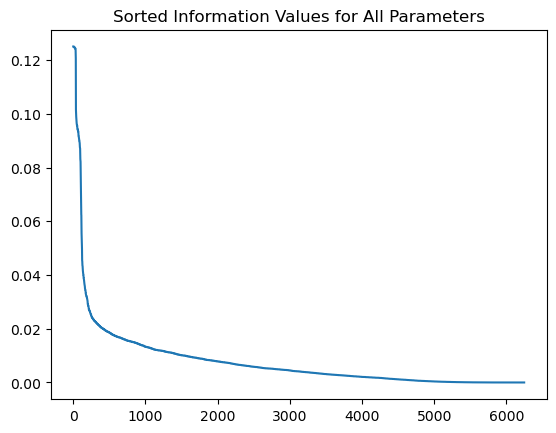

C:\Users\user\AppData\Local\Temp\ipykernel_9840\3920410950.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


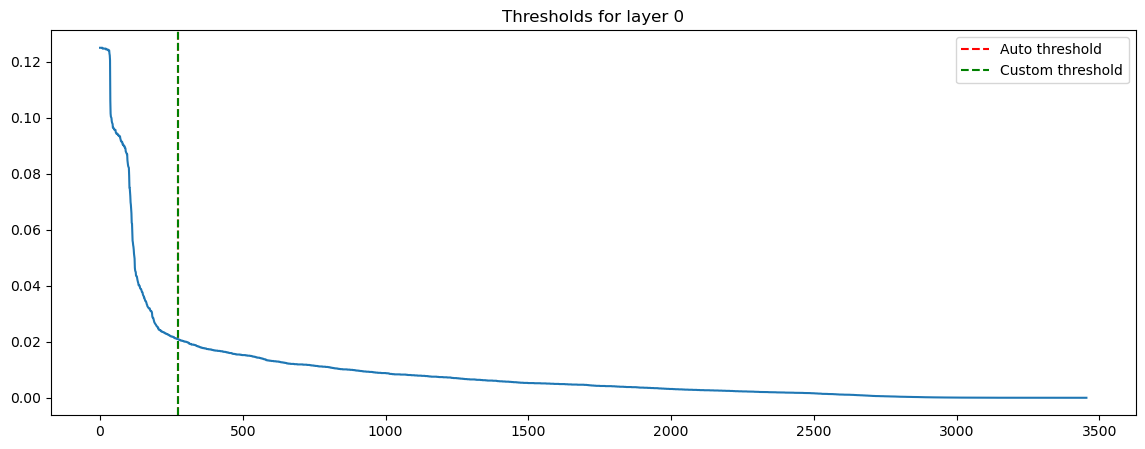

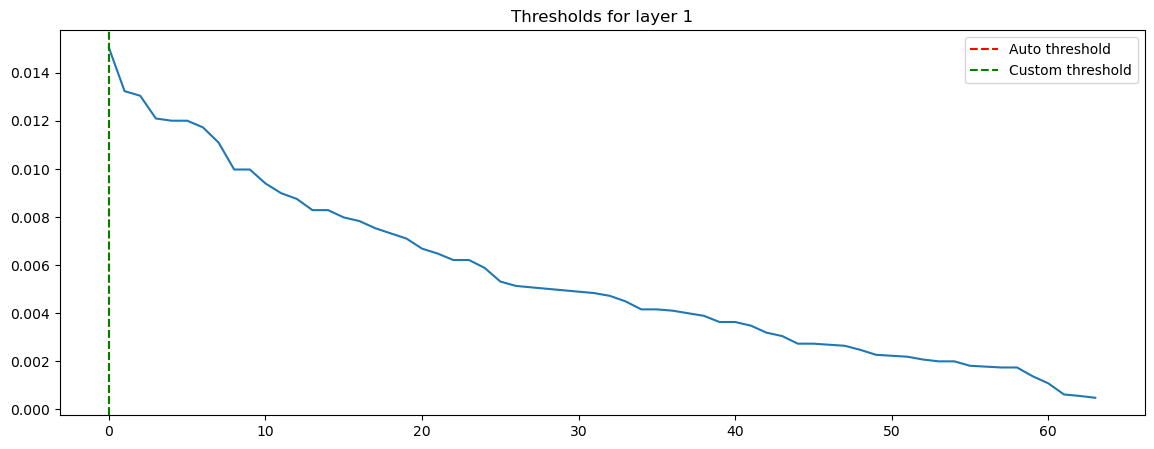

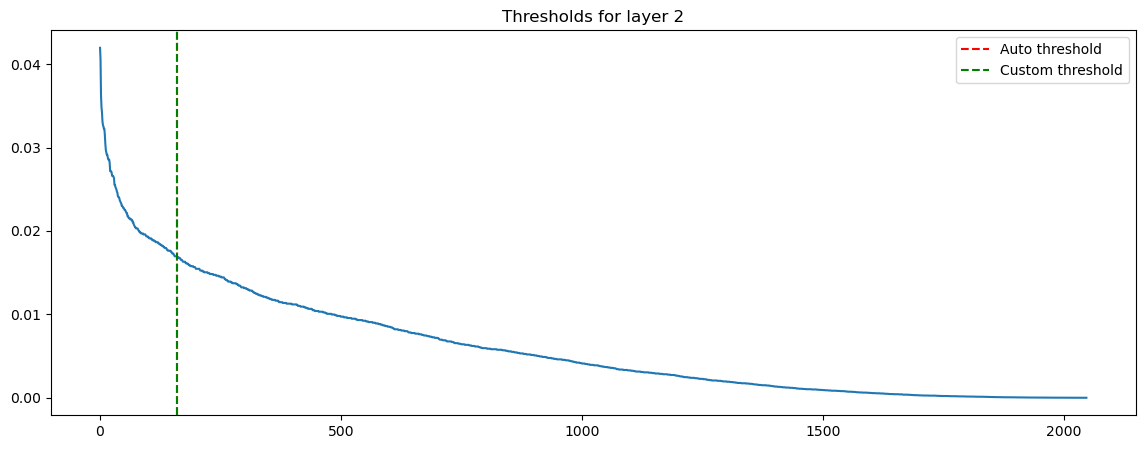

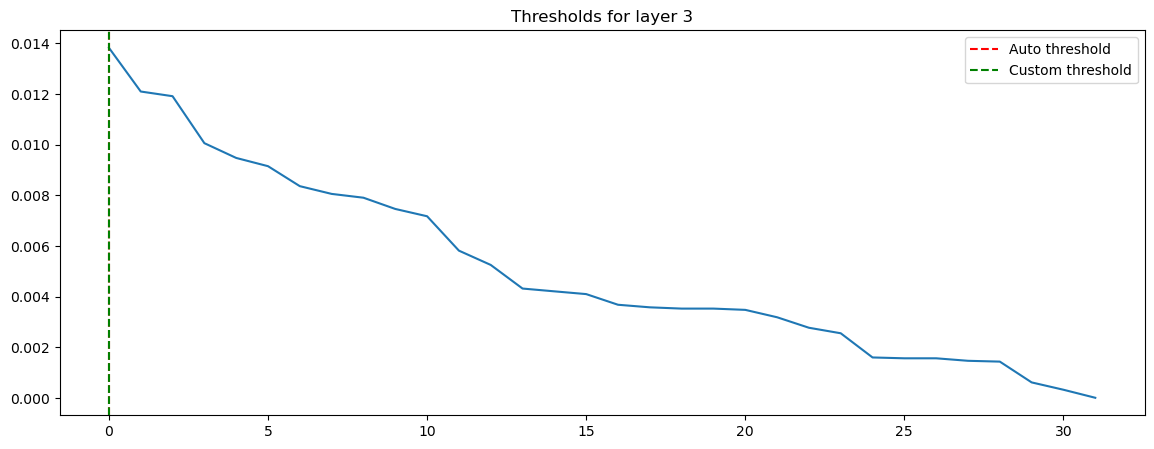

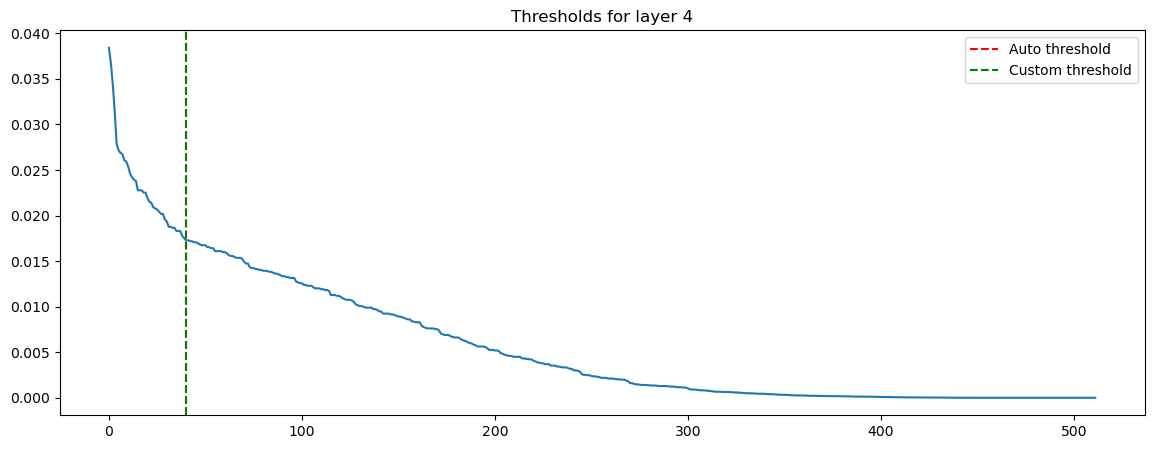

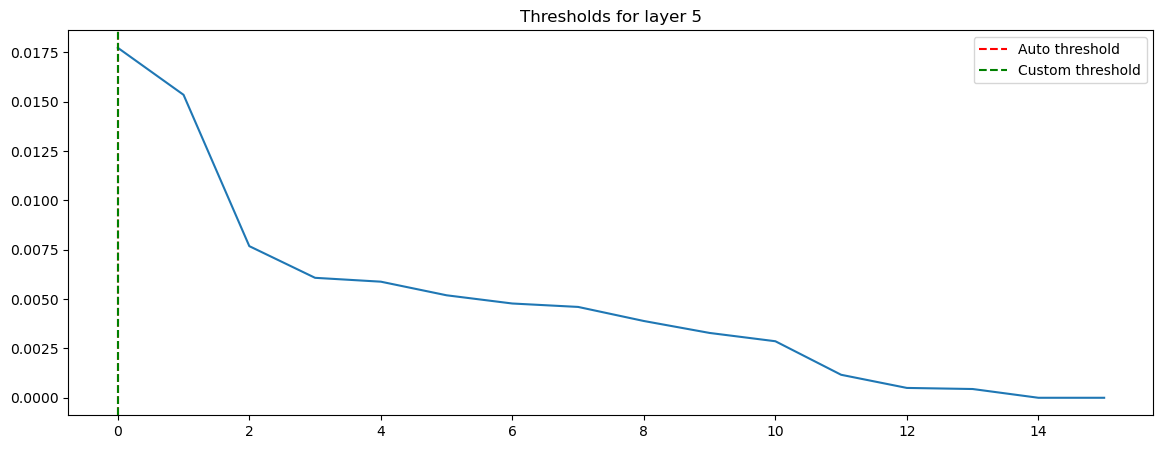

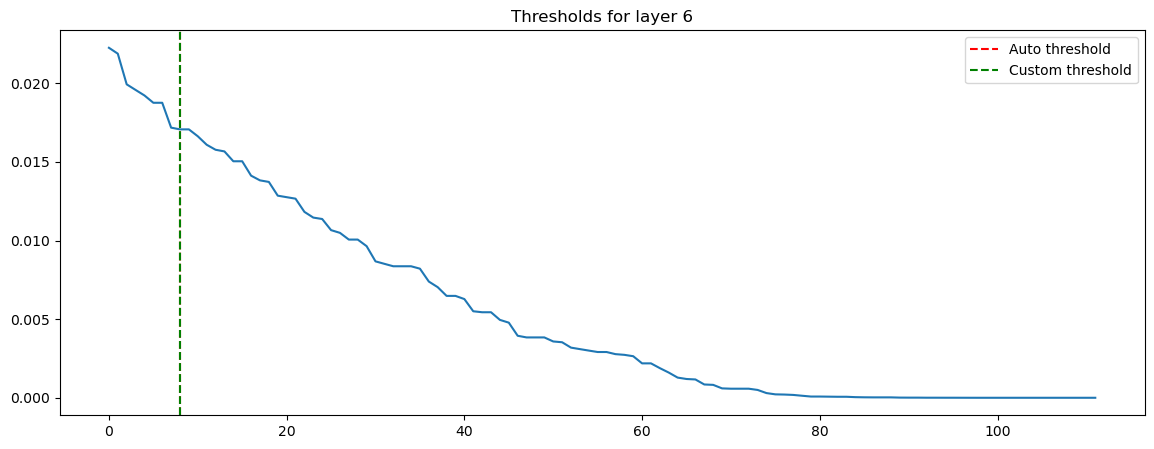

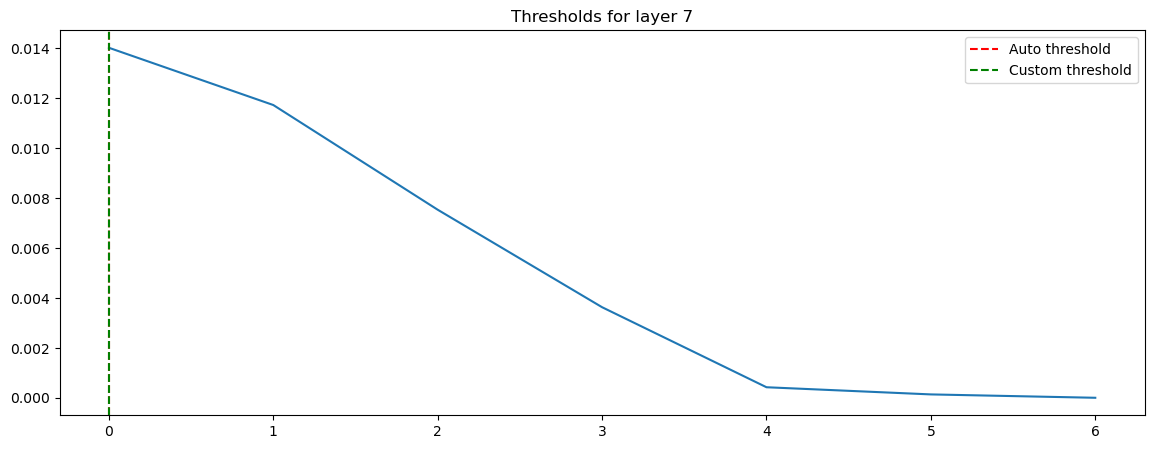

In [23]:
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))[::-1]

s_infolayers = [np.sort(p.cpu().flatten())[::-1] for p in info_true]

plt.plot(s_infocat)
plt.title('Sorted Information Values for All Parameters')
plt.show()

# from kneed import KneeLocator
# start = [0, 0, 0, 0, 0, 0, 0, 0]
# end = [-1, -1, -10000, -30, -1, -1, -1, -1]
# step = [1, 1, 1, 1, 100, 1, 1, 1]
# auto_thresholds = []
# for i in range(len(s_infolayers)):
#     kneedle = KneeLocator(range(len(s_infolayers[i][start[i]:end[i]:step[i]])), s_infolayers[i][start[i]:end[i]:step[i]], curve='convex', direction='decreasing', online=True)
#     auto_thresholds.append(start[i]+kneedle.knee*step[i])
#     print(f'Layer {i} knee:', auto_thresholds[i])

auto_percentage = 8
custom_percentages = [None, None, None, None, None, None, None, None]

percentages = [auto_percentage if custom_percentages[i] is None else custom_percentages[i] for i in range(len(custom_percentages))]

auto_thresholds = [len(s_infolayers[i]) // 100 * percentages[i] for i in range(len(s_infolayers))]

custom_thresholds = [None, None, None, None, None, None, None, None]

thresholds = [auto_thresholds[i] if custom_thresholds[i] is None else custom_thresholds[i] for i in range(len(custom_thresholds))]

for i in range(len(s_infolayers)):
    fig, axs = plt.subplots(1, 1, figsize=(14, 5))
    axs.plot(s_infolayers[i])
    axs.axvline(auto_thresholds[i], color='red', linestyle='--', label='Auto threshold')
    axs.axvline(thresholds[i], color='green', linestyle='--', label='Custom threshold')
    axs.legend()
    axs.set_title(f'Thresholds for layer {i}')
    fig.show()

    


Parameters reset unlearning

In [24]:
thresholds_values = [p[thresholds[i]] for i,p in enumerate(s_infolayers)]
retrain_param_indices = []
for i, p in enumerate(info_true):
    if custom_thresholds[i] != 0:
        indices = torch.argwhere(p > thresholds_values[i])
        retrain_param_indices.append(indices)
    else:
        retrain_param_indices.append(torch.empty(size=[0 for _ in range(p.dim())]))

model_reset = copy.deepcopy(net).cpu()
model_null = Net(n_inputs, n_classes)

original_parameters = model_reset.state_dict()
null_parameters = model_null.state_dict()

reset_parameters = {}
for i, (name, p) in enumerate(model_reset.named_parameters()):
    new_p = original_parameters[name].clone()
    null_p = null_parameters[name].clone()
    #new_p[tuple(retrain_param_indices[i].t())] = null_p[tuple(retrain_param_indices[i].t())]
    new_p[tuple(retrain_param_indices[i].t())] = 0
    reset_parameters[name] = new_p

model_reset.load_state_dict(reset_parameters)

print("Accuracy before resetting:")
test_accuracy, test_conf_mat = validate(net, test_dl, n_classes, device)
print(test_accuracy)
plot_confusion_matrix(test_conf_mat)
print("Accuracy after resetting:")
test_accuracy, test_conf_mat = validate(model_reset, test_dl, n_classes, device)
print(test_accuracy)
plot_confusion_matrix(test_conf_mat)

Accuracy before resetting:
tensor(0.6794, device='cuda:0')


,0,1,2,3,4,5,6
0,127,49,1,0,6,1,17
1,45,127,2,0,31,4,4
2,0,4,114,38,15,76,0
3,0,0,6,165,0,9,0
4,12,29,12,0,181,10,0
5,0,5,53,16,18,128,0
6,35,1,0,0,0,0,171


Accuracy after resetting:
tensor(0.6187, device='cuda:0')


,0,1,2,3,4,5,6
0,177,0,1,0,4,2,17
1,173,0,2,0,29,4,5
2,0,0,114,39,14,80,0
3,0,0,5,166,0,9,0
4,55,0,13,0,161,14,1
5,6,0,53,17,11,133,0
6,41,0,0,0,0,0,166


In [25]:
def print_info_stats(information):
    """
    Compute statistics for the information values.
    """
    # Flatten the information values and convert to numpy
    layers_total_information = [torch.sum(p) for p in information]

    for i, info in enumerate(layers_total_information):
        print(f"Layer {i} - Total Information: {info:.4f}")
    
    print(f"Total Information: {sum(layers_total_information):.4f}")

print("Information before resetting:")
print_info_stats(info_true)

reset_info_true = copy.deepcopy(info_true)
for i in range(len(reset_info_true)):
    reset_info_true[i][tuple(retrain_param_indices[i].t())] = 0
print("Information after resetting:")
print_info_stats(reset_info_true)

Information before resetting:
Layer 0 - Total Information: 33.1103
Layer 1 - Total Information: 0.3521
Layer 2 - Total Information: 12.5354
Layer 3 - Total Information: 0.1642
Layer 4 - Total Information: 3.0301
Layer 5 - Total Information: 0.0795
Layer 6 - Total Information: 0.6252
Layer 7 - Total Information: 0.0375
Total Information: 49.9342
Information after resetting:
Layer 0 - Total Information: 16.9766
Layer 1 - Total Information: 0.3521
Layer 2 - Total Information: 9.0200
Layer 3 - Total Information: 0.1642
Layer 4 - Total Information: 2.1014
Layer 5 - Total Information: 0.0795
Layer 6 - Total Information: 0.4676
Layer 7 - Total Information: 0.0375
Total Information: 29.1988


In [ ]:
class UnlearnNet(nn.Module):
    """
    A module that wraps an existing model and selectively retrains individual 
    scalar elements (indices) of its parameters while keeping the rest fixed.
    """

    def __init__(self, base_model, indices_to_retrain):
        """
        Args:
            base_model (nn.Module): The original model whose parameters 
                                    we want to partially retrain.
            indices_to_retrain (List[torch.Tensor]): For each parameter of 
                                    'base_model', a tensor of indices indicating 
                                    which scalar values should be retrained.
        """
        super().__init__()

        # We store the base model inside a dictionary to allow
        # functional calls later without overshadowing state_dict keys.
        self.inner_model = {"model": base_model}

        # Move any index tensors to CPU and store them.
        self.indices_to_retrain = [idx.cpu() for idx in indices_to_retrain]

        # Create a copy of the base model's parameters as buffers, where
        # we zero out the positions that will be retrained.
        base_params = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            # Detach a clone of the original parameter
            cloned_param = param.clone().detach()
            # Zero-out the entries we plan to retrain
            if len(self.indices_to_retrain[i]) > 0:
                cloned_param[tuple(self.indices_to_retrain[i].t())] = 0
            base_params[param_name] = cloned_param

        # Register these base parameters as buffers so they are not optimized
        for param_name, buf in base_params.items():
            buf_name = param_name.replace(".", "_")
            self.register_buffer(f"base_{buf_name}", buf)

        # Create the new learnable parameters for only the chosen indices
        retrain_params_dict = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # We create a 1D tensor (one entry per retrained element)
            key = param_name.replace(".", "_")
            retrain_params_dict[key] = nn.Parameter(
                torch.zeros(len(self.indices_to_retrain[i]))
            )
        self.retrain_params = nn.ParameterDict(retrain_params_dict)

        # Build sparse masks to apply the learnable values at the correct indices
        sparse_masks = {}
        for i, (param_name, param) in enumerate(base_model.named_parameters()):
            if len(self.indices_to_retrain[i]) == 0:
                continue
            # 'retrain_indices' has shape (k, n_dims). Add a final dim to index positions in the retrain-param vector.
            retrain_indices = indices_to_retrain[i]
            k = retrain_indices.size(0)

            # Create an index column [0..k-1], then concatenate it with 'retrain_indices'.
            row_idx = torch.arange(k).unsqueeze(1)
            final_idx_matrix = torch.cat([retrain_indices, row_idx], dim=1)

            # A sparse_coo_tensor expects indices with shape (ndim, nnz). Transpose to (n_dims+1, k).
            indices_for_sparse = final_idx_matrix.t().contiguous()

            # Append k as the final dimension so each retrained element indexes differently.
            mask_shape = tuple(param.size()) + (k,)

            # Build the sparse mask with 1.0 at the retrained indices.
            key = f"mask_{param_name.replace('.', '_')}"
            sparse_masks[key] = torch.sparse_coo_tensor(
                indices_for_sparse,
                torch.ones(k, dtype=torch.float32),
                size=mask_shape
            )
        
        # Register these sparse masks as buffers
        for mask_name, mask in sparse_masks.items():
            self.register_buffer(mask_name, mask.coalesce())

    def contract_last_dim_with_vector(self, sp_tensor: torch.Tensor, vec: torch.Tensor) -> torch.Tensor:
        """
        Contract the last dimension of a sparse tensor (shape [..., N]) with
        a dense vector of shape (N,), returning a sparse tensor of shape [...].

        This effectively applies elementwise multiplication with 'vec'
        across the last dimension of 'sp_tensor'.
        """

        # Extract indices (shape [ndim, nnz]) and values (shape [nnz])
        indices = sp_tensor.indices()
        values = sp_tensor.values()

        # Multiply each sparse value by the corresponding element in 'vec'
        # indices[-1] indicates which element in 'vec' to use per sparse entry
        new_values = values * vec[indices[-1]]

        # Create a new sparse_coo_tensor with one fewer dimension
        new_shape = sp_tensor.shape[:-1]
        new_indices = indices[:-1, :]  # drop the last dimension index row

        result_tensor = torch.sparse_coo_tensor(
            new_indices,
            new_values,
            size=new_shape,
            dtype=sp_tensor.dtype,
            device=sp_tensor.device
        )

        return result_tensor

    def forward(self, x):
        """
        Forward pass using a functional call to the base model. We reconstruct 
        final parameters by adding the base buffers and the contracted retrain 
        parameters at the relevant indices.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )

        # Perform a functional forward pass with the reconstructed parameters
        return torch.func.functional_call(model, final_params, x)
    
    def get_retrained_params(self):
        """
        Returns the retrained parameters of the model.
        """
        model = self.inner_model["model"]
        current_state = self.state_dict()

        # Rebuild parameter dict from buffers (base params)
        final_params = {}
        for param_name in model.state_dict().keys():
            buf_name = param_name.replace(".", "_")
            final_params[param_name] = current_state[f"base_{buf_name}"]

        # Add in the learnable values at specified indices
        for key, param_vector in self.retrain_params.items():
            mask_key = f"mask_{key}"
            base_key = f"base_{key}"
            original_param_name = key.replace("_", ".")

            # Convert sparse mask to shape that can be added to base param
            sparse_update = self.contract_last_dim_with_vector(
                current_state[mask_key], param_vector
            )

            # Add the sparse update to the base buffer
            final_params[original_param_name] = (
                current_state[base_key] + sparse_update
            )
        
        detached_params = {}
        for key, value in final_params.items():
            detached_params[key] = value.cpu().detach()
        return detached_params
    

In [27]:
#Test
unlearn_model = UnlearnNet(model_reset, retrain_param_indices)

print("Unlearn model parameters:")
for name , param in unlearn_model.named_parameters():
    print(name, param.shape)

Unlearn model parameters:
retrain_params.0_weight torch.Size([269])
retrain_params.2_weight torch.Size([160])
retrain_params.4_weight torch.Size([40])
retrain_params.6_weight torch.Size([8])


In [28]:
num_of_repeats = 1
num_fl_rounds = 5

#fusion_types = ['FedAvg','Retrain']
fusion_types = ['FedAvg']
fusion_types_unlearn = ['Retrain', 'Unlearn']

num_updates_in_epoch = None
num_local_epochs = 2

dist_Retrain = {}
loss_fed = {}
grad_fed = {}
clean_accuracy = {}
pois_accuracy = {}
for fusion_key in fusion_types:
    loss_fed[fusion_key] = np.zeros(num_fl_rounds)
    grad_fed[fusion_key] = np.zeros(num_fl_rounds)
    clean_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    pois_accuracy[fusion_key] = np.zeros(num_fl_rounds)
    if fusion_key != 'Retrain':
        dist_Retrain[fusion_key] = np.zeros(num_fl_rounds)

In [37]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.empty_cache()

party_models_dict = {}
initial_model = unlearn_model
model_dict = {}
parties = list(range(7))
print(parties)
del parties[party_to_be_erased]

for fusion_key in fusion_types:
    model_dict[fusion_key] = copy.deepcopy(initial_model.state_dict())

for round_num in range(num_fl_rounds):
    local_training = LocalTraining(num_updates_in_epoch=num_updates_in_epoch, num_local_epochs=num_local_epochs)

    for fusion_key in fusion_types:
        fusion = FL_round_fusion_selection(num_parties=len(parties), fusion_key=fusion_key)

        current_model_state_dict = copy.deepcopy(model_dict[fusion_key])
        model = copy.deepcopy(initial_model)
        model.load_state_dict(current_model_state_dict)

        ##################### Local Training Round #############################
        party_models = []
        party_losses = []
        party_grad   = []        
        for party_id in parties:

            if fusion_key == 'Retrain':
                break
            else:
                print(f"Training party {party_id}")
                model = UnlearnNet(model_reset, retrain_param_indices)
                model.load_state_dict(current_model_state_dict)
                model.to(device)
                model_update, party_loss = local_training.train(model=model,
                                            trainloader=trainloader_lst[party_id],
                                            device = device,
                                            criterion=None, opt = torch.optim.Adam(params=model.parameters(), lr=1e-2))
                model_update_copy = UnlearnNet(model_reset, retrain_param_indices)
                model_update_copy.load_state_dict(model_update.state_dict())
                model_update_copy.to("cpu")
                party_models.append(model_update_copy)
                party_losses.append(party_loss)

            grad_norm = 0.0
            for name,param in model_update.named_parameters():
                if param.grad is not None:
                    grad_norm += torch.norm(param.grad).cpu().item()
                    #print(f"Gradient norm for {name}: {grad_norm}")
                else:
                    #print(f"Gradient is None for {name}")
                    pass
        
            party_grad.append(grad_norm)   
        
        grad_fed[fusion_key][round_num] += (np.mean(party_grad)/num_of_repeats) 

        loss_fed[fusion_key][round_num] += (np.mean(party_losses)/num_of_repeats)
        ######################################################################

        current_model_state_dict = fusion.fusion_algo(party_models=party_models, current_model=model)

        eval_model = copy.deepcopy(initial_model).to("cpu")
        eval_model.load_state_dict(current_model_state_dict)
        clean_acc = Utils.evaluate(test_dl, eval_model)
        clean_accuracy[fusion_key][round_num] = clean_acc
        print(f'Global Clean Accuracy {fusion_key}, round {round_num} = {clean_acc}')

[0, 1, 2, 3, 4, 5, 6]
Training party 0
Training party 2
Training party 3
Training party 4
Training party 5
Training party 6
Global Clean Accuracy FedAvg, round 0 = 61.77248677248677
Training party 0
Training party 2
Training party 3
Training party 4
Training party 5
Training party 6
Global Clean Accuracy FedAvg, round 1 = 62.301587301587304
Training party 0
Training party 2
Training party 3
Training party 4
Training party 5
Training party 6
Global Clean Accuracy FedAvg, round 2 = 62.56613756613756
Training party 0
Training party 2
Training party 3
Training party 4
Training party 5
Training party 6
Global Clean Accuracy FedAvg, round 3 = 62.301587301587304
Training party 0
Training party 2
Training party 3
Training party 4
Training party 5
Training party 6
Global Clean Accuracy FedAvg, round 4 = 62.235449735449734


In [39]:
print("Accuracy after retrain")
test_accuracy, test_conf_mat = validate(eval_model, test_dl, n_classes, device)
print(test_accuracy)
plot_confusion_matrix(test_conf_mat)

Accuracy after retrain
tensor(0.6227, device='cuda:0')


,0,1,2,3,4,5,6
0,167,0,1,0,14,2,17
1,144,0,2,0,55,7,5
2,0,0,192,17,14,24,0
3,0,0,38,140,0,2,0
4,27,0,19,0,188,10,0
5,5,0,107,8,13,87,0
6,37,0,0,0,3,0,167


In [ ]:
trainloader_list = [DataLoader(dloader.dataset, batch_size=20) for dloader in trainloader_lst]
#trainloader_list_removed, num_removed = create_dataloader(party_to_be_erased, trainloader_list, 0.8) 


final_model = Net(n_inputs, n_classes)
unlearned_params = eval_model.get_retrained_params()


final_model.load_state_dict(unlearned_params)
final_model = extend(final_model)

criterion = nn.CrossEntropyLoss()
criterion = extend(criterion)

delta = 0.01

# Create weights list
weights_unlearned = [1] * len(trainloader_list)
weights_unlearned[party_to_be_erased] = 0
weights_delta = weights_unlearned.copy()
weights_delta[party_to_be_erased] = delta

weights_unlearned=torch.tensor(weights_unlearned, dtype=torch.float32)
weights_delta=torch.tensor(weights_delta, dtype=torch.float32)

accumulated_diag_h_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_unlearned)
accumulated_diag_h_removed_retrain = calculate_accumulated_diag_hessian(trainloader_list, final_model, criterion, weights_delta)


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
info_true = compute_true_info(accumulated_diag_h_retrain, accumulated_diag_h_removed_retrain, torch.as_tensor([delta]).to(device))

plot_information(info_true)

In [ ]:
client0 = torch.load("client0")
client1 = torch.load("client1")
client2 = torch.load("client2")
client3 = torch.load("client3")
client4 = torch.load("client4")

def count_equal_arrays(list1, list2):
    equal_count = 0
    min_length = min(len(list1), len(list2))
    
    for i in range(min_length):
        if np.array_equal(list1[i], list2[i]):
            print(list1[i])
            equal_count += 1
    
    return equal_count

count_equal_arrays(client4[6], client4[6])


def tensor_list_distance(list1, list2, metric='euclidean'):
    """
    Compute various distance metrics between two lists of tensors.
    
    Args:
        list1: First list of tensors
        list2: Second list of tensors
        metric: Distance metric to use ('euclidean', 'manhattan', 'cosine', 'mean_squared', 'element_diff')
        
    Returns:
        float: The computed distance between the two tensor lists
    """
    # Make sure we only compare up to the length of the shorter list
    min_length = min(len(list1), len(list2))
    
    if min_length == 0:
        raise ValueError("At least one of the lists is empty")
        
    # Initialize distance
    distances = []
    
    # Compute distance for each pair of tensors
    for i in range(min_length):
        tensor1 = list1[i].float()  # Ensure tensors are float type
        tensor2 = list2[i].float()
        
        if metric == 'euclidean':
            # Euclidean distance
            dist = torch.sqrt(torch.sum((tensor1 - tensor2) ** 2)).item()
            distances.append(dist)
            
        elif metric == 'manhattan':
            # Manhattan (L1) distance
            dist = torch.sum(torch.abs(tensor1 - tensor2)).item()
            distances.append(dist)
            
        elif metric == 'cosine':
            # Cosine distance (1 - cosine similarity)
            dot_product = torch.sum(tensor1 * tensor2)
            norm1 = torch.sqrt(torch.sum(tensor1 ** 2))
            norm2 = torch.sqrt(torch.sum(tensor2 ** 2))
            
            # Avoid division by zero
            if norm1 == 0 or norm2 == 0:
                dist = 1.0  # Maximum distance
            else:
                cosine_sim = dot_product / (norm1 * norm2)
                # Clip to handle floating point errors
                cosine_sim = torch.clamp(cosine_sim, -1.0, 1.0)
                dist = 1.0 - cosine_sim.item()
                
            distances.append(dist)
            
        elif metric == 'mean_squared':
            # Mean squared error
            dist = torch.mean((tensor1 - tensor2) ** 2).item()
            distances.append(dist)
            
        elif metric == 'element_diff':
            # Count of different elements
            diff_count = torch.sum(tensor1 != tensor2).item()
            distances.append(diff_count)
            
        else:
            raise ValueError(f"Unknown distance metric: {metric}")
    
    # Compute average distance across all tensor pairs
    avg_distance = np.mean(distances)
    
    # Calculate additional statistics
    stats = {
        "mean": avg_distance,
        "median": np.median(distances),
        "min": np.min(distances),
        "max": np.max(distances),
        "std": np.std(distances),
        "distances": distances  # List of all pairwise distances
    }
    
    return stats

    
# Compute distances using different metrics
for metric in ['euclidean', 'element_diff']:
    result = tensor_list_distance(client0[4], client1[4], metric=metric)
    print(f"\n{metric.upper()} Distance:")
    print(f"Mean: {result['mean']:.6f}")
    print(f"Median: {result['median']:.6f}")
    print(f"Min: {result['min']:.6f}")
    print(f"Max: {result['max']:.6f}")
    print(f"Std: {result['std']:.6f}")
